In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [2]:
class StationarMaterial:
    def __init__(self, Ms, gamma=5e8, alpha=0.1, Ku=7e6, t=12e-7):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Ku = Ku
        self.t = t

        
class Material:
    def __init__(self, stationar):
        self.st = stationar
        
        self.Ms_l = lambda t: self.st.Ms
        self.gamma_l = lambda t: self.st.gamma
        self.alpha_l = lambda t: self.st.alpha
        self.Ku_l = lambda t: self.st.Ku
        self.t_l = lambda t: self.st.t
    
    def set_Ku_lambda(self, Ku_lambda):
        self.Ku_l = Ku_lambda

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J

In [3]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector


class DemagnetizationEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Mz = symbols("Mz")
        self.E_eq = 2*sym.pi*(Mz**2)
        
    def Heff(self, M):
        return np.array([0., 0., -4.*np.pi*M[2]])

class StoenerWolfarthEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Ku = symbols("Ku")
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        sin_tet_sqr = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
        
        self.E_eq = Ku*sin_tet_sqr
        
        Hx = -sym.diff(self.E_eq, Mx)
        Hy = -sym.diff(self.E_eq, My)
        Hz = -sym.diff(self.E_eq, Mz)
        
        lambda_var_set = (Ku, Mx, My, Mz)
        self.Heff_x = lambdify(lambda_var_set, Hx, 'numpy')
        self.Heff_y = lambdify(lambda_var_set, Hy, 'numpy')
        self.Heff_z = lambdify(lambda_var_set, Hz, 'numpy')
    
    def Heff(self, M, Ku):
        return np.array([
            self.Heff_x(Ku, M[0], M[1], M[2]),
            self.Heff_y(Ku, M[0], M[1], M[2]),
            self.Heff_z(Ku, M[0], M[1], M[2])
        ])

class IEC_Energy:
    def __init__(self):
        S = CoordSys3D('S')
        
        J, t = symbols("J t")
        
        Mx1, My1, Mz1 = symbols('Mx1 My1 Mz1')
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        
        Mx2, My2, Mz2 = symbols('Mx2 My2 Mz2')
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        self.E_eq = (J/t)*M1.dot(M2)/(M1.magnitude()*M2.magnitude())
        
        Hx1 = -sym.diff(self.E_eq, Mx1)
        Hy1 = -sym.diff(self.E_eq, My1)
        Hz1 = -sym.diff(self.E_eq, Mz1)
        
        Hx2 = -sym.diff(self.E_eq, Mx2)
        Hy2 = -sym.diff(self.E_eq, My2)
        Hz2 = -sym.diff(self.E_eq, Mz2)
        
        lambda_var_set = (
            J, t,
            Mx1, My1, Mz1,
            Mx2, My2, Mz2
        )
        
        self.Heff_x1 = lambdify(lambda_var_set, Hx1, 'numpy')
        self.Heff_y1 = lambdify(lambda_var_set, Hy1, 'numpy')
        self.Heff_z1 = lambdify(lambda_var_set, Hz1, 'numpy')
        
        self.Heff_x2 = lambdify(lambda_var_set, Hx2, 'numpy')
        self.Heff_y2 = lambdify(lambda_var_set, Hy2, 'numpy')
        self.Heff_z2 = lambdify(lambda_var_set, Hz2, 'numpy')
        
    def Heff1(self, M1, M2, J, t1):
        return [
            self.Heff_x1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_y1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_z1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2])
        ]
    
    def Heff2(self, M1, M2, J, t2):
        return [
            self.Heff_x2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_y2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_z2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2])
        ]

In [4]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
    
    def right_hand(self, Heff, M, layer, t):
        x = self.sol_lamb['x'](
            layer.alpha_l(t), layer.gamma_l(t), np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            layer.alpha_l(t), layer.gamma_l(t), np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            layer.alpha_l(t), layer.gamma_l(t), np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    


In [14]:
from scipy import optimize

class StationaryState:
    def __init__(self):
        S = CoordSys3D('S')
        Mx1, My1, Mz1 = symbols("M_x1 M_y1 M_z1")
        Mx2, My2, Mz2 = symbols("M_x2 M_y2 M_z2")
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        Hx, Hy, Hz = symbols("H_x H_y H_z")
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        Ku1, Ku2, J = symbols("K_u1 K_u2 J")
        t1, t2 = symbols("t1 t2")
        
        self.Ze1 = -H.dot(M1)
        self.Ze2 = -H.dot(M2)
        
        self.SW_D1 = Ku1*(Mx1**2 + My1**2)/(Mx1**2 + My1**2 + Mz1**2) + 2*sym.pi*(Mz1**2)
        self.SW_D2 = Ku2*(Mx2**2 + My2**2)/(Mx2**2 + My2**2 + Mz2**2) + 2*sym.pi*(Mz2**2)
        
        self.Ev1 = self.Ze1 + self.SW_D1
        self.Ev2 = self.Ze2 + self.SW_D2
        
        self.Es = J*M1.dot(M2)/(M1.magnitude()*M2.magnitude()) + t1*self.Ev1 + t2*self.Ev2
        
        
        
        Ze1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz
        )
        self.Ze1_lamb = lambdify(Ze1_varset, self.Ze1, 'numpy')
        
        Ze2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz
        )
        self.Ze2_lamb = lambdify(Ze2_varset, self.Ze2, 'numpy')
        
        
        
        SW_D1_varset = (
            Mx1, My1, Mz1,
            Ku1
        )
        self.SW_D1_lamb = lambdify(SW_D1_varset, self.SW_D1, 'numpy')
        
        SW_D2_varset = (
            Mx2, My2, Mz2,
            Ku2
        )
        self.SW_D2_lamb = lambdify(SW_D2_varset, self.SW_D2, 'numpy')
        
        
        Ev1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz,
            Ku1
        )
        
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
        Ev2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku2
        )
        
        self.Ev2_lamb = lambdify(Ev2_varset, self.Ev2, 'numpy')
        
        
        Es_varset = (
            Mx1, My1, Mz1,
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku1, Ku2,
            J,
            t1, t2
        )
        
        self.Es_lamb = lambdify(Es_varset, self.Es, 'numpy')
    
    
    def get_angles(
        self,
        film,
        Hext,
        tol = None,
        N = 10
    ):  
        func_l = lambda x: self.funcmin(x, film, Hext)
        
        best_res = 0
        min_E = 1e10
        for i in range(N):
            res = optimize.minimize(
                func_l, 
                x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                bounds=[(0,np.pi),(0,2*np.pi),(0,np.pi),(0,2*np.pi)], 
                tol = tol
            )
            
            if func_l(res.x)<min_E:
                best_res = res
                min_E = func_l(res.x)
        
        print(best_res)
        return best_res.x
    
        
    def funcmin(self, x, film, Hext):
        tet1 = x[0]
        phi1 = x[1]
        M1 = pol2cart(film.l1.st.Ms, tet1, phi1)
    
        tet2 = x[2]
        phi2 = x[3]
        M2 = pol2cart(film.l2.st.Ms, tet2, phi2)
        
        return self.Es_lamb(
            M1[0], M1[1], M1[2],
            M2[0], M2[1], M2[2],
            Hext[0], Hext[1], Hext[2],
            film.l1.st.Ku, film.l2.st.Ku,
            film.J,
            film.l1.st.t, film.l2.st.t        
        )
        
        
    def plot_energy(
        self, 
        film,
        Hext,
        N = 1000,
        
        ang0_diap_grad = np.array([0., 180.]),
        ang1_diap_grad = np.array([0., 180.]),
        sign = 1
    ):  
        ang0_diap_rad = np.deg2rad(ang0_diap_grad)
        ang1_diap_rad = np.deg2rad(ang1_diap_grad)
        
        ang1 = np.linspace(ang0_diap_rad[0], ang0_diap_rad[1], N)
        ang2 = np.linspace(ang1_diap_rad[0], ang1_diap_rad[1], N)
        
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            M1 = pol2cart(film.l1.st.Ms, ang1[i], 0.)
            M2 = pol2cart(film.l2.st.Ms, ang2, 0.)
            Es_val[i] = self.Es_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku, film.l2.st.Ku,
                film.J,
                film.l1.st.t, film.l2.st.t
            )
        
        fig, ax = plt.subplots()
        fig.set_figheight(6)
        fig.set_figwidth(6)
        ax.imshow(sign * np.log(Es_val - Es_val.min() + 1e-5))
        fig.tight_layout()
        
        ticks = np.arange(0, N + 1, N//5)
        ticks[-1]-=1
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.set_xticklabels(np.linspace(ang0_diap_grad[0], ang0_diap_grad[1], 6))
        ax.set_yticklabels(np.linspace(ang1_diap_grad[0], ang1_diap_grad[1], 6))      
        
st_state = StationaryState()

In [6]:
equation = LLG_EQ()
demagnet_eq = DemagnetizationEnergy()
StWo_eq = StoenerWolfarthEnergy()
IEC_eq = IEC_Energy()


mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)


#estimate values from hysteresis loop
Ms_hyst = 800.
Ku1_hyst = 2*np.pi*(Ms_hyst**2) + 0.78e4*Ms_hyst/2.
Ku2_hyst = 2*np.pi*(Ms_hyst**2) + 0.78e4*Ms_hyst/2.
J_hyst = ((1.33-0.78)*1e4 * Ms_hyst/2.)*12e-7

#external field
Hext_abs = 3e3
Hext_tet = np.deg2rad(63.0)
Hext = np.array(pol2cart(Hext_abs, Hext_tet, 0.0))

#dynamic parameters
t_start = 2e-10
#Ku dynamic
Ku_d = Ku1_hyst * (0.003)
Ku_tau = 12e-12
Ku_t0 = t_start
#M dynamic
M_d = 1.
M_tau = 110e-12
M_t_grow = 2e-12
M_t0 = t_start


#setting up film parameters
layer1 = Material(
    StationarMaterial(
        Ms=Ms_hyst, 
        gamma=2.2*g0_CGS, alpha=0.1,
        Ku=Ku1_hyst,
        t=12e-7
    )
)
layer2 = Material(
    StationarMaterial(
        Ms=Ms_hyst, 
        gamma=2.2*g0_CGS, alpha=0.1,
        Ku=Ku2_hyst,
        t=12e-7
    )
)

#laser excitation
def Ku_func(t, Ku):
    if t < Ku_t0:
        return Ku
    else:
        return Ku - Ku_d*np.exp(-(t-Ku_t0)/Ku_tau)

layer1.set_Ku_lambda(lambda t: Ku_func(t, layer1.st.Ku))
layer2.set_Ku_lambda(lambda t: Ku_func(t, layer2.st.Ku))

film_inst = LayeredFilm(layer1, layer2, J_hyst)




#model for solvation (Heff_function() + model())

def Heff_function(M1, M2, film, t):
    Heff1 = Hext + demagnet_eq.Heff(M1) + StWo_eq.Heff(M1, film.l1.Ku_l(t)) + IEC_eq.Heff1(M1, M2, film.J, film.l1.st.t)
    Heff2 = Hext + demagnet_eq.Heff(M2) + StWo_eq.Heff(M2, film.l2.Ku_l(t)) + IEC_eq.Heff2(M1, M2, film.J, film.l2.st.t)
    
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst, t)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1, t)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2, t)
    
    #addition of Ms derivative
    ort_M1 = M1/np.linalg.norm(M1)
    ort_M2 = M2/np.linalg.norm(M2)
    if t>M_t0:
        LLG1 += (M_d/M_tau)*np.exp(-(t-M_t0)/M_tau)*ort_M1
        LLG2 += (M_d/M_tau)*np.exp(-(t-M_t0)/M_tau)*ort_M2
        
    elif t>M_t0-M_t_grow and t<M_t0:
        LLG1 -= M_d/M_t_grow * ort_M1
        LLG2 -= M_d/M_t_grow * ort_M2
    
    return np.append(LLG1, LLG2)


#estimating stationary position to start from
angles = st_state.get_angles(
    film_inst,
    Hext
)

print("tet1 = {:.4f},  phi1 = {:.4f}".format(np.rad2deg(angles[0]), np.rad2deg(angles[1])))
print("tet2 = {:.4f},  phi2 = {:.4f}".format(np.rad2deg(angles[2]), np.rad2deg(angles[3])))

M01 = pol2cart(film_inst.l1.st.Ms, angles[0] + np.deg2rad(0.), angles[1])
M02 = pol2cart(film_inst.l2.st.Ms, angles[2] - np.deg2rad(0.), angles[3])
M01_M02 = np.append(M01, M02)


time_span = [0.0, 1000.0e-12]
sol = solve_ivp(model, time_span, M01_M02, t_eval=np.linspace(time_span[0], time_span[1],int(1e5)),
                method = 'RK45', max_step=1e-13)


df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

      fun: 0.17019779403662766
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.33146837e-07,  0.00000000e+00, -1.16573418e-07, -0.00000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 65
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([2.89897609, 0.        , 0.17005954, 6.28318531])
tet1 = 166.0991,  phi1 = 0.0000
tet2 = 9.7437,  phi2 = 360.0000


,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,72.073014,0.000000e+00,-291.213806,300.000000,50.772310,-1.243563e-14,295.672407,300.000000
1,1.000010e-14,72.073014,3.795602e-08,-291.213806,300.000000,50.772310,-2.300938e-08,295.672407,300.000000
2,2.000020e-14,72.073014,7.589899e-08,-291.213806,300.000000,50.772310,-4.600843e-08,295.672407,300.000000
3,3.000030e-14,72.073014,1.138288e-07,-291.213806,300.000000,50.772310,-6.899708e-08,295.672407,300.000000
4,4.000040e-14,72.073014,1.517454e-07,-291.213806,300.000000,50.772310,-9.197522e-08,295.672407,300.000000
...,...,...,...,...,...,...,...,...,...
99995,9.999600e-10,72.066464,2.006826e-05,-291.205772,299.990628,50.768777,-1.049210e-05,295.663505,299.990628
99996,9.999700e-10,72.066464,2.006592e-05,-291.205772,299.990628,50.768777,-1.049107e-05,295.663505,299.990628
99997,9.999800e-10,72.066464,2.006359e-05,-291.205772,299.990628,50.768777,-1.049003e-05,295.663505,299.990628
99998,9.999900e-10,72.066464,2.006125e-05,-291.205772,299.990628,50.768777,-1.048899e-05,295.663505,299.990628


<IPython.core.display.Javascript object>


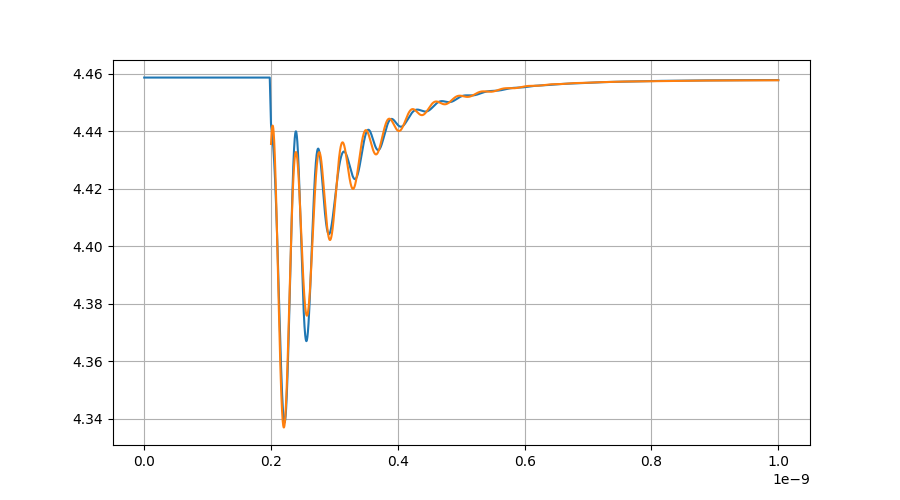

In [17]:
%matplotlib notebook
plt.subplots(figsize = (9, 5))
plt.plot(df.t, df.z1 + df.z2)
#plt.plot(df.t, df.y1 + df.y2)
#plt.plot(df.t, df.z1)
#plt.plot(df.t, df.z2)
plt.grid(True)

In [18]:
from scipy.optimize import curve_fit

def func3(x, fi0, f, tau1, tau2, tau3, A1, A2, A3, C):
    #       1-oscillations                                      2-M relaxation              3-Ku relaxation
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) + A3*np.exp(-(x-Ku_t0)/tau3)


par, ss = curve_fit(
    func3,
    df.t[df.t>M_t0],
    df.z2[df.t>M_t0] + df.z1[df.t>M_t0],
    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
    p0=[0, 18e9, 100e-12, M_tau, Ku_tau, 2., 1., 2., 0.],
    maxfev=1000
)

print(par)
print("f={} GHz".format(par[1]*1e-9))

plt.plot(df.t[df.t>M_t0], func3(df.t[df.t>M_t0], *par))

[-1.28634545e+01  2.73536330e+10  6.46704434e-11  1.03959573e-10
  5.05121969e-11 -1.49772069e+00 -1.06857051e-01  2.43766684e-02
  4.45770518e+00]
f=27.353632966817877 GHz


<IPython.core.display.Javascript object>


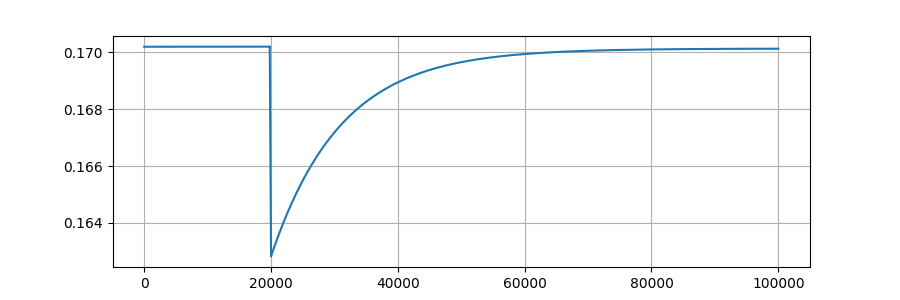

In [25]:
%matplotlib notebook
#for now not valid for dynamic parameters
Es_of_tragectory = st_state.Es_lamb(
    df.x1, df.y1, df.z1,
    df.x2, df.y2, df.z2,
    Hext[0], Hext[1], Hext[2],
    film_inst.l1.st.Ku, film_inst.l2.st.Ku,
    film_inst.J,
    film_inst.l1.st.t, film_inst.l2.st.t
)

Es_of_tragectory.plot(figsize = (9,3))
plt.grid(True)


<IPython.core.display.Javascript object>


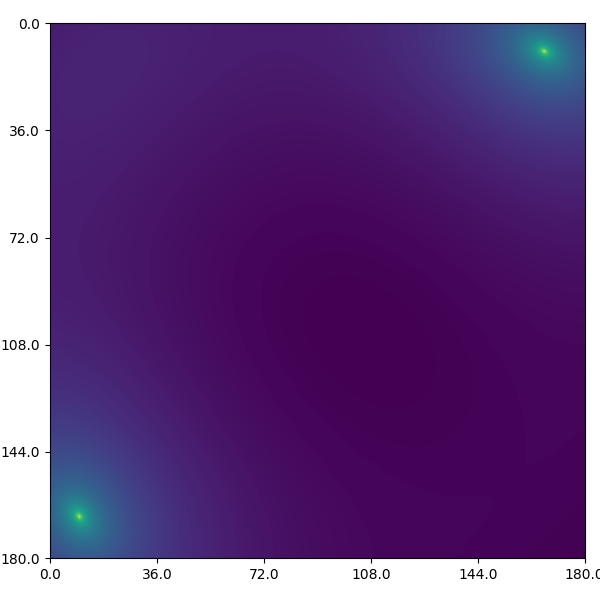

||H|| = 3000.0


In [20]:
%matplotlib notebook

st_state.plot_energy(
    film_inst,
    Hext,
    
    N = 1000,
    ang0_diap_grad = np.array([0., 180.]),
    ang1_diap_grad = np.array([0., 180.]),
    sign = -1
)
print("||H|| = {}".format(Hext_abs))

<IPython.core.display.Javascript object>


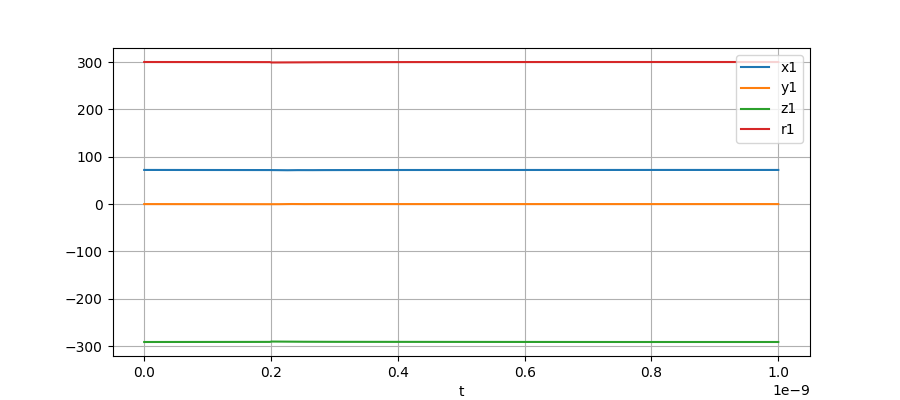

In [28]:
%matplotlib notebook

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (9, 4))
plt.grid(True)

<IPython.core.display.Javascript object>


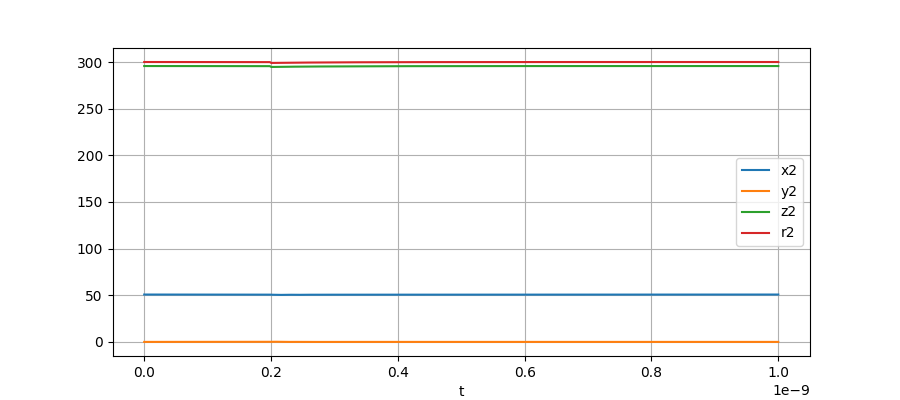

In [29]:
%matplotlib notebook

df.plot(x='t', y=['x2', 'y2', 'z2', 'r2'], figsize = (9, 4))
plt.grid(True)

0.9999900000000002

'delta: 0.9999900000000002'

<IPython.core.display.Javascript object>


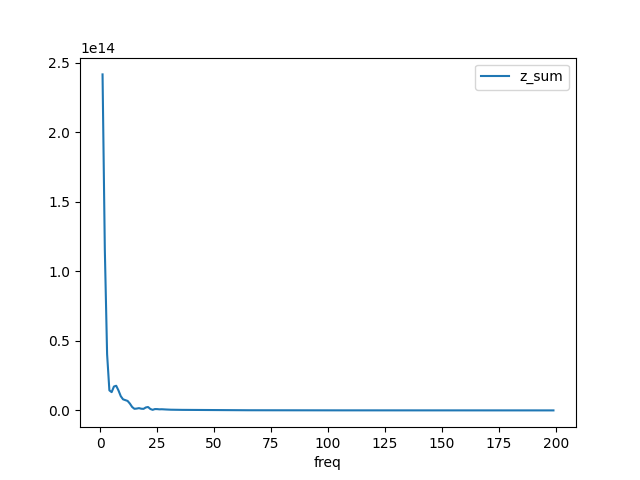

,freq,x1,y1,z1,x2,y2,z2,z_sum
0,0.99999,4.667587e+13,1.643839e+13,3.933978e+13,7.887484e+13,6.540176e+12,8.862124e+13,2.416777e+14
1,1.99998,4.143226e+13,2.261303e+13,2.390080e+13,5.513474e+13,1.599606e+13,4.419552e+13,1.157781e+14
2,2.99997,2.954421e+13,2.621211e+13,2.080215e+13,2.973414e+13,1.919225e+13,1.292490e+13,4.044722e+13
3,3.99996,1.515249e+13,2.174869e+13,2.105709e+13,1.192166e+13,1.230846e+13,1.297804e+12,1.442676e+13
4,4.99995,5.289530e+12,1.144021e+13,1.689764e+13,6.122054e+12,2.659439e+12,3.577952e+12,1.314244e+13
...,...,...,...,...,...,...,...,...
194,194.99805,8.006075e+07,3.865064e+09,3.366571e+09,7.545075e+07,3.866165e+09,3.361097e+09,1.345533e+10
195,195.99804,7.938623e+07,3.827016e+09,3.336992e+09,7.392020e+07,3.828011e+09,3.329013e+09,1.333201e+10
196,196.99803,7.851501e+07,3.786515e+09,3.298443e+09,7.365666e+07,3.787092e+09,3.292911e+09,1.318270e+10
197,197.99802,7.753100e+07,3.745997e+09,3.257676e+09,7.394460e+07,3.746395e+09,3.256165e+09,1.302768e+10


In [13]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:200] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:200]**2

freq_df["z_sum"] = np.abs(np.fft.fft(df.z1 + df.z2))[1:200]**2

display(freq_df['freq'][freq_df['z1'].argmax()])
display("delta: {}".format(freq_df.freq[1]-freq_df.freq[0]))
#freq_df.plot(x='freq', y=['x1','y1', 'z1', 'x2', 'y2', 'z2'])
freq_df.plot(x='freq', y=['z_sum'])
freq_df

# Legacy Code

<IPython.core.display.Javascript object>


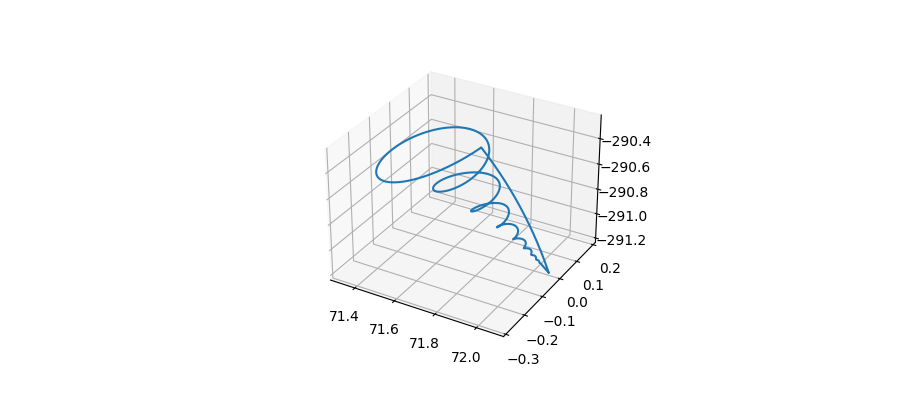

In [37]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

In [6]:
%load_ext jupyter_spaces

In [91]:
%%space space1

S = CoordSys3D('S')

Mx, My, Mz = symbols("M_x M_y M_z")
M = S.i*Mx + S.j*My + S.k*Mz

Hx, Hy, Hz = symbols("H_x H_y H_z")
H = S.i*Hx + S.j*Hy + S.k*Hz

Ku = symbols("K_u")

sin_tet2 = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
Ev = -H.dot(M) + 2*sym.pi*(M.dot(S.k)**2) + Ku*sin_tet2

varset = (
    Mx, My, Mz,
    Hx, Hy, Hz,
    Ku
)
Ev_lamb = lambdify(varset, Ev)



-H_x*M_x - H_y*M_y - H_z*M_z + K_u*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2) + 2*pi*M_z**2

In [ ]:
%%space space2
